<a href="https://colab.research.google.com/github/vinismachadoo/otimizacao-petroleo-offshore/blob/main/producao_bacia_campos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import acos, cos, sin
from pulp import LpProblem, LpVariable, LpMinimize, LpStatus, lpSum, value
import warnings

warnings.filterwarnings("ignore")

In [2]:
CAMPOS_EM_PRODUCAO = 'http://hmlapp5.anp.gov.br/geoserver/oracleworskspace/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=oracleworskspace:CAMPOS_PRODUCAO_SIRGAS&outputFormat=JSON'
MUNICIPIOS_RJ = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/UFs/RJ/rj_municipios.zip'
UEPS_OPERACAO = 'https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/lpo/dados-abertos-ueps-operacao-1.csv'

In [3]:
campos_producao = gpd.read_file(CAMPOS_EM_PRODUCAO)

In [4]:
municipios_rj = gpd.read_file(MUNICIPIOS_RJ)

In [5]:
bacia_campos = campos_producao[campos_producao.NOM_BACIA == 'Campos']

In [6]:
ueps_operacao = pd.read_csv(UEPS_OPERACAO, sep=';')
plataformas = ueps_operacao[ueps_operacao['Bacia '] == 'Campos '].set_index('Sigla')

In [7]:
plataformas_latitude = plataformas.Latitude.str.replace(",",".").str.split(":", expand=True)
plataformas['latitude_decimal'] = plataformas_latitude[0].astype(int) - plataformas_latitude[1].astype(float) / 60 - plataformas_latitude[2].astype(float) / 3600
plataformas['latitude_radianos'] = np.deg2rad(plataformas['latitude_decimal'])

plataformas_longitude = plataformas.Longitude.str.replace(",",".").str.split(":", expand=True)
plataformas['longitude_decimal'] = plataformas_longitude[0].astype(int) - plataformas_longitude[1].astype(float) / 60 - plataformas_longitude[2].astype(float) / 3600
plataformas['longitude_radianos'] = np.deg2rad(plataformas['longitude_decimal'])

In [8]:
DEMANDA = {
    'FPSO': 45,
    'FIXA': 45,
    'SEMI SUBMERSÍVEL': 73,
    'FPU': 55,
    'TLWP': 55
}

plataformas['demanda'] = plataformas.Tipo.map(DEMANDA)

In [9]:
plataformas.head()

,Nome,Bacia,Tipo,Operador,Latitude,Longitude,Lâmina D'água (m),Capacidade de Processamento Petróleo (bbl/dia),Capacidade de Processamento Gás (Mil m³/dia),latitude_decimal,latitude_radianos,longitude_decimal,longitude_radianos,demanda
Sigla,,,,,,,,,,,,,,
CAPX,FPSO CAPIXABA,Campos,FPSO,Petrobras,"-21:14:16,783","-39:57:46,397",1350,110000,3200,-21.237995,-0.370673,-39.962888,-0.697484,45
FCDA,FPSO CIDADE DE ANCHIETA,Campos,FPSO,Petrobras,"-21:20:16,965","-40:03:27,174",1221,100000,3500,-21.338046,-0.372419,-40.057548,-0.699136,45
FPCGZ,FPSO Cidade de Campos dos Goytacazes,Campos,FPSO,Petrobras,"-22:57:12,165","-40:43:31,966",765,150000,3500,-22.953379,-0.400612,-40.725546,-0.710795,45
FPSO ESP SANTO,FPSO ESPIRITO SANTO,Campos,FPSO,Shell Brasil,"-21:12:30,854","-39:44:33,774",1775,100000,1400,-21.208571,-0.370159,-39.742715,-0.693641,45
FPSO FLUMINENSE,FPSO Fluminense,Campos,FPSO,Shell Brasil,"-22:38:57,206","-40:25:43,286",607,70000,2124,-22.649224,-0.395304,-40.428691,-0.705614,45


In [10]:
AEROPORTOS_DATA = {
    'Sigla': ['SBCP', 'SBME', 'SBFS', 'SBCB'],
    'maxFrota': [20, 20, 10, 20],
    'maxPatio': [364, 364, 182, 364],
    'Latitude': ['-21:42:04', '-22:20:34', '-22:01:44', '-22:55:15'],
    'Longitude': ['-41:18:28', '-41:45:50', '-41:04:11', '-42:04:17']
}
aeroportos = pd.DataFrame(AEROPORTOS_DATA).set_index('Sigla')

aeroportos_latitude = aeroportos.Latitude.str.replace(",",".").str.split(":", expand=True)
aeroportos['latitude_decimal'] = aeroportos_latitude[0].astype(int) - aeroportos_latitude[1].astype(float) / 60 - aeroportos_latitude[2].astype(float) / 3600
aeroportos['latitude_radianos'] = np.deg2rad(aeroportos['latitude_decimal'])

aeroportos_longitude = aeroportos.Longitude.str.replace(",",".").str.split(":", expand=True)
aeroportos['longitude_decimal'] = aeroportos_longitude[0].astype(int) - aeroportos_longitude[1].astype(float) / 60 - aeroportos_longitude[2].astype(float) / 3600
aeroportos['longitude_radianos'] = np.deg2rad(aeroportos['longitude_decimal'])

In [11]:
aeroportos

,maxFrota,maxPatio,Latitude,Longitude,latitude_decimal,latitude_radianos,longitude_decimal,longitude_radianos
Sigla,,,,,,,,
SBCP,20,364,-21:42:04,-41:18:28,-21.701111,-0.378756,-41.307778,-0.720957
SBME,20,364,-22:20:34,-41:45:50,-22.342778,-0.389955,-41.763889,-0.728917
SBFS,10,182,-22:01:44,-41:04:11,-22.028889,-0.384477,-41.069722,-0.716802
SBCB,20,364,-22:55:15,-42:04:17,-22.920833,-0.400044,-42.071389,-0.734284


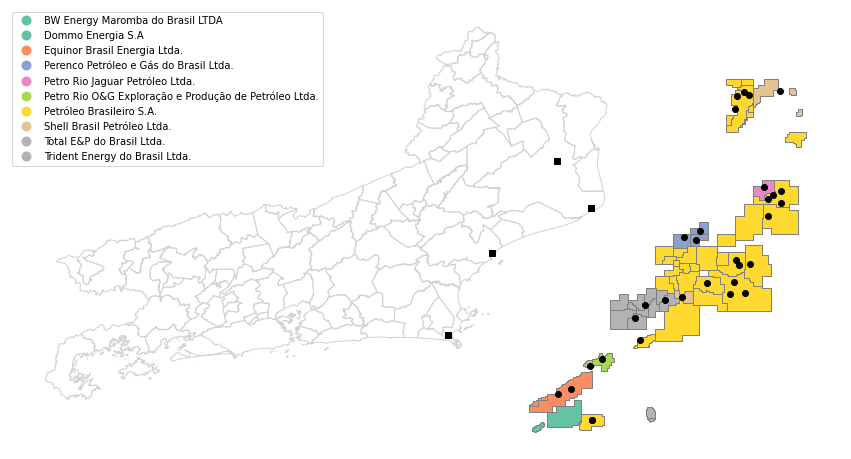

In [12]:
fig, ax = plt.subplots(figsize = (15,10))
bacia_campos.plot(ax=ax, ec='gray', column='OPERADOR_C', cmap='Set2', legend=True, legend_kwds={'loc': 'upper left'})
municipios_rj.plot(ax=ax, fc='None', ec='lightgray')
ax.scatter(plataformas['longitude_decimal'], plataformas['latitude_decimal'], color='black')
ax.scatter(aeroportos['longitude_decimal'], aeroportos['latitude_decimal'], color='black', marker='s')

sns.despine(left=True, bottom=True)
ax.set_yticks([])
ax.set_xticks([])

plt.show()

In [13]:
OPERADORES = set(plataformas.Operador.unique())
PLATAFORMAS = set(plataformas.index)
AEROPORTOS = set(aeroportos.index)

In [14]:
def calcula_distancia(p,a):
    d = 2*6378*acos(
        cos(
            plataformas['longitude_radianos'][p] - aeroportos['longitude_radianos'][a]
        )*cos(
            plataformas['latitude_radianos'][p]
        )*cos(
            aeroportos['latitude_radianos'][a]
        )+sin(
            plataformas['latitude_radianos'][p]
        )*sin(
            aeroportos['latitude_radianos'][a]
        ))
    return d

distancia = {}
for p in PLATAFORMAS:
    dd = {a:calcula_distancia(p,a) for a in AEROPORTOS}
    distancia[p] = dd

In [15]:
permicao = {}
for o in OPERADORES:
    oo = {p: (1 if plataformas.Operador[p] == o else 0) for p in PLATAFORMAS}
    permicao[o] = oo

In [16]:
HELICOPTERO_DATA = {
    'assentos': 13,
    'maxVoos': 14,
}

In [17]:
pb = LpProblem('Facility', LpMinimize)
x = LpVariable.dicts('x', (OPERADORES, PLATAFORMAS, AEROPORTOS), cat='Binary')
y = LpVariable.dicts('y', (OPERADORES, AEROPORTOS), cat='Integer')
z = LpVariable.dicts('z', (OPERADORES, PLATAFORMAS, AEROPORTOS), cat='Integer')
pb += lpSum([[[distancia[p][a] * z[o][p][a] + 1_000_000 * y[o][a] for o in OPERADORES] for p in PLATAFORMAS] for a in AEROPORTOS])

for o in OPERADORES:
    for p in PLATAFORMAS:
        # Uma plataforma tem que ser atendida por um, e apenas um, aeroporto
        pb += lpSum([x[o][p][a] for a in AEROPORTOS]) == permicao[o][p]
        # O aeroporto SBFS só pode atender plataformas da Petrobras
        pb += x[o][p]['SBFS'] <= permicao['Petrobras'][p]
        for a in AEROPORTOS:
            pb += z[o][p][a] >= plataformas['demanda'][p] * x[o][p][a] / HELICOPTERO_DATA['assentos']

for a in AEROPORTOS:
    # Número limitado de decolagens no aeroporto
    pb += lpSum([[z[o][p][a] for o in OPERADORES] for p in PLATAFORMAS]) <= aeroportos['maxPatio'][a]
    # Número limitado de frota disponivel no aeroporto
    pb += lpSum([y[o][a] for o in OPERADORES]) <= aeroportos['maxFrota'][a]
    for o in OPERADORES:
        # Existe uma quantidade limite de voos que uma aeronave pode fazer por semana
        pb += lpSum([z[o][p][a] for p in PLATAFORMAS]) <= y[o][a] * HELICOPTERO_DATA['maxVoos']

pb.solve()
print("Status:", LpStatus[pb.status])

Status: Optimal


In [18]:
for v in pb.variables():
    if value(v) >= 1:
        print(v, "=", value(v))

x_Chevron_Frade_FPSO_FRADE_SBCP = 1.0
x_Dommo_Energia_OSX3_SBCB = 1.0
x_Equinor_Brasil_PEREGRINO_A_SBCB = 1.0
x_Equinor_Brasil_PEREGRINO_B_SBCB = 1.0
x_Perenco_Brasil_PCP_II_SBCP = 1.0
x_Perenco_Brasil_PPG_1A_SBCP = 1.0
x_Perenco_Brasil_PVM_3_SBCP = 1.0
x_Petro_Rio_O&G_POLVO_A_SBCB = 1.0
x_Petrobras_CAPX_SBFS = 1.0
x_Petrobras_FCDA_SBFS = 1.0
x_Petrobras_FPCGZ_SBFS = 1.0
x_Petrobras_PCE_1_SBFS = 1.0
x_Petrobras_PPM_1_SBFS = 1.0
x_Petrobras_P_08_SBFS = 1.0
x_Petrobras_P_18_SBFS = 1.0
x_Petrobras_P_19_SBFS = 1.0
x_Petrobras_P_40_SBFS = 1.0
x_Petrobras_P_43_SBFS = 1.0
x_Petrobras_P_50_SBFS = 1.0
x_Petrobras_P_51_SBFS = 1.0
x_Petrobras_P_52_SBFS = 1.0
x_Petrobras_P_53_SBFS = 1.0
x_Petrobras_P_54_SBFS = 1.0
x_Petrobras_P_55_SBFS = 1.0
x_Petrobras_P_56_SBFS = 1.0
x_Petrobras_P_57_SBFS = 1.0
x_Petrobras_P_58_SBFS = 1.0
x_Petrobras_P_61_SBCB = 1.0
x_Petrobras_P_62_SBFS = 1.0
x_Petrobras_P_63_SBCB = 1.0
x_Shell_Brasil_FPSO_ESP_SANTO_SBCP = 1.0
x_Shell_Brasil_FPSO_FLUMINENSE_SBCP = 1.0
y_Chevron

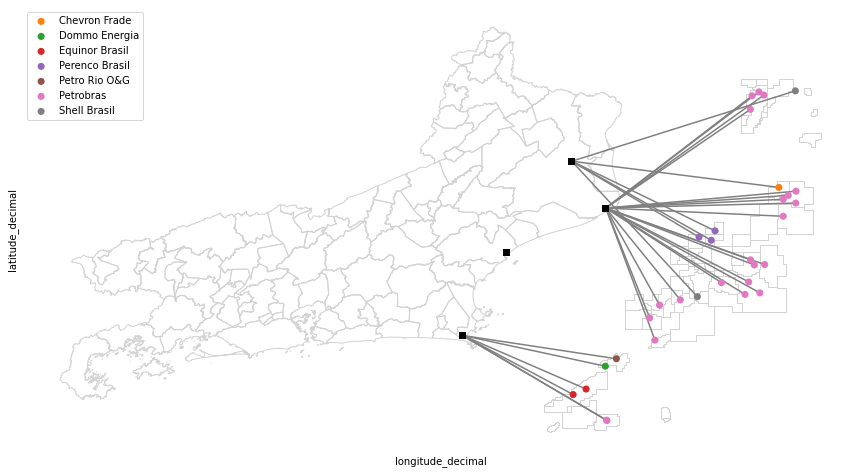

In [19]:
fig, ax = plt.subplots(figsize = (15,10))
bacia_campos.plot(ax=ax, fc='None', ec='lightgray')
municipios_rj.plot(ax=ax, fc='None', ec='lightgray')
sns.scatterplot(x='longitude_decimal', y='latitude_decimal', data=aeroportos, ax=ax, marker='s', s=50, ec='None', fc='black', zorder=2)
for name, group in plataformas.groupby('Operador'):
    sns.scatterplot(x='longitude_decimal', y='latitude_decimal', data=group, label=name, ax=ax, s=50, ec='None', zorder=2)
for o in OPERADORES:
    for p in PLATAFORMAS:
        for a in AEROPORTOS:
            if value(x[o][p][a]) == 1:
                ax.plot([plataformas.longitude_decimal[p], aeroportos.longitude_decimal[a]],
                        [plataformas.latitude_decimal[p], aeroportos.latitude_decimal[a]], color='gray', zorder=1)

sns.despine(left=True, bottom=True)
ax.set_yticks([])
ax.set_xticks([])

plt.show()